In [7]:
import pandas as pd
import functions
import names as n
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats

In [8]:
'''# This method just loads 2 dataframes and merge them together and save it into data folder
df = functions.load_ga_hits_and_ga_sessions_and_merge()

# We need target columns for prediction
functions.create_target_column_into_df(df)

df = df.sort_values(by=["is_target"], ascending=False)

df = df.drop_duplicates(subset=["session_id"], keep="first")

df.to_csv('data/merged_ga_hits_and_ga_sessions.csv', index=False)'''




# Here we just read it
df = pd.read_csv('data/merged_ga_hits_and_ga_sessions.csv')
print(df.shape)
df.head(3)

# I understand we need to predict: 
# ['sub_car_claim_click', 'sub_car_claim_submit_click',
# 'sub_open_dialog_click', 'sub_custom_question_submit_click',
# 'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
# 'sub_car_request_submit_click'] from event_action

# It means customer visit the site, so we need to understand he will click at target or not. 
# And after that we can do something with these type of people 
# For example who with big probability almost 100% we are not going to do something. 
# But if customer with 40%-60% we can do something to provocate their interest more.
# And if customer with 0%-30% we are not going do to something

(1732266, 28)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_label,event_value,is_target
0,7284725054902084534.1624538941.1624538941,1.696107e+09,2021-06-24,15:00:00,75,jaSOmLICuBzCFqHfBdRg,email,LliRUcMuIXWdLyWHGyiO,sDWYAbLNiGZVxGBDdTxc,NaN,...,2021-06-24,NaN,22,event,HbolMJUevblAbkHClEQa,sberauto.com/cars/4791c8b2?rental_page=rental_car,sub_submit,nsPPIRqjxBefONGPpnsF,NaN,1
1,2502982653972912560.1628266799.1628266799,5.827711e+08,2021-08-06,19:00:00,6,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,...,2021-08-06,NaN,35,event,HbolMJUevblAbkHClEQa,sberauto.com/cars/f28947a1?rental_page=rental_car,sub_button_click,EsLbNNEnCkXWoaesnKlS,NaN,1
2,63501960694916780.1640162989.1640162989,1.478520e+07,2021-12-22,11:49:49,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,...,2021-12-22,90012.0,20,event,NaN,sberauto.com/cars/all/skoda/octavia/4791c8b2?u...,sub_button_click,EsLbNNEnCkXWoaesnKlS,NaN,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 float64
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  hit_date                  object 
 19  hit_time                  float64
 20  hit_number              

In [3]:
# Let's check about nulls columns
how_many_nulls = df.isnull().sum()
(how_many_nulls.sort_values(ascending=False) / len(df))*100

event_value                 100.000000
device_model                 99.130503
utm_keyword                  58.925823
device_os                    58.533966
hit_time                     58.499388
hit_referer                  38.840167
event_label                  29.462277
device_brand                 20.042880
utm_adcontent                17.557177
utm_campaign                 11.273500
utm_source                    0.004387
hit_date                      0.000000
hit_page_path                 0.000000
event_category                0.000000
hit_type                      0.000000
hit_number                    0.000000
session_id                    0.000000
device_screen_resolution      0.000000
geo_city                      0.000000
geo_country                   0.000000
device_browser                0.000000
client_id                     0.000000
device_category               0.000000
utm_medium                    0.000000
visit_number                  0.000000
visit_time               

In [4]:
df.is_target.value_counts()

0    1681952
1      50314
Name: is_target, dtype: int64

In [5]:
# We don't need columns with missing values more than 80%
df = functions.get_dropped_df_with_80_percent_or_more_miss_values_in_columns(df)

# We need hours, minutes, seconds from visit time
functions.add_hms_columns_from_visit_time_into_df(df)
df = df.drop(columns=[n.c.VISIT_TIME, n.c.VISIT_TIME_DT])

# We need year, month, day from visit date
functions.add_ymd_columns_from_visit_date_into_df(df)
df = df.drop(columns=[n.c.VISIT_DATE, n.c.VISIT_DATE_DT])

# We will try to create column with width x height resolution column
functions.create_mult_device_screen_resolution_column_into_df(df)
df = df.drop(columns=[n.c.DEVICE_SCREEN_RESOLUTION])

functions.create_is_from_russia_column_from_geo_country_columns(df)

# We don't need client_id for prediction
df = df.drop(columns=[n.c.CLIENT_ID])

df.sample(1)

,session_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,...,visit_time_minutes,visit_time_seconds,visit_time_full_minutes,visit_time_full_hours,visit_date_year,visit_date_month,visit_date_day,visit_date_weekday,device_screen_resolution_mult,is_from_russia
1370662,4004463479324212482.1629814018.1629814018,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,dUuXlWzvmhDSyclWRhNP,NaN,mobile,NaN,Xiaomi,...,0,0,0.0,17.0,2021,8,24,1,343089,1


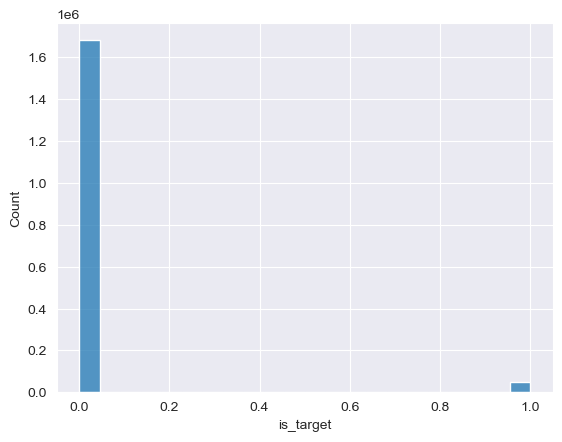

In [6]:
# We have a lot more 'False' than 'True'
sns.histplot(data=df, x=n.c.IS_TARGET);

In [21]:
df.nunique()

session_id                       1732266
visit_number                         533
utm_source                           280
utm_medium                            55
utm_campaign                         406
utm_adcontent                        280
utm_keyword                         1192
device_category                        3
device_os                             13
device_brand                         200
device_browser                        55
geo_country                          159
geo_city                            2389
hit_date                             226
hit_time                          195547
hit_number                           374
hit_type                               1
hit_referer                        23737
hit_page_path                     199659
event_category                        46
event_label                         5170
event_value                            0
is_target                              2
visit_time_hours                      24
visit_time_minut

In [22]:
# We need to reduce categorical values in columns. Ratio means which category less than ration we change category into 'else'
functions.create_new_columns_with_else_values_in_it(df, n.c.UTM_SOURCE, n.c.UTM_SOURCE_CUSTOMISED, ratio=0.001)
functions.create_new_columns_with_else_values_in_it(df, n.c.UTM_MEDIUM, n.c.UTM_MEDIUM_CUSTOMISED, ratio=0.001)
functions.create_new_columns_with_else_values_in_it(df, n.c.UTM_CAMPAIGN, n.c.UTM_CAMPAIGN_CUSTOMISED, ratio=0.001)
functions.create_new_columns_with_else_values_in_it(df, n.c.UTM_ADCONTENT, n.c.UTM_ADCONTENT_CUSTOMISED, ratio=0.001)
functions.create_new_columns_with_else_values_in_it(df, n.c.UTM_KEYWORD, n.c.UTM_KEYWORD_CUSTOMISED, ratio=0.001)
functions.create_new_columns_with_else_values_in_it(df, n.c.DEVICE_BRAND, n.c.DEVICE_BRAND_CUSTOMISED, ratio=0.001)
functions.create_new_columns_with_else_values_in_it(df, n.c.GEO_CITY, n.c.GEO_CITY_CUSTOMISED, ratio=0.001)

# Just to check how it works
df[n.c.UTM_CAMPAIGN_CUSTOMISED].value_counts()

LTuZkdKfxRGVceoWkVyg    422992
LEoPHuyFvzoNfnzGgfcd    321286
else                    266922
FTjNLDyTrXaWYgZymFkV    234950
gecBYcKZCPMcVYdSSzKP    133247
XHNUiSKKGTEpSAlaVMFQ     23750
sbJRYgVfvcnqKJNDDYIr     19942
okTXSMadDkjvntEHzIjp     18405
LwJZxKuWmvOhPsaCeRjG     16846
SgIUDYUKnyWHVowUOqid     15784
RoDitORHdzGfGhNCyEMy     15063
bxOTvPtyGSdUrbwoXCPO     14987
TmThBvoCcwkCZZUWACYq     14878
zxoiLxhuSIFrCeTLQVWZ     12234
bJJuEXRheRIxXEaYIXqM     11903
YCKgTzTDywjcWyQudGch     11735
nSReTmyFtbSjlPrTKoaX     11272
QEejXfOCtOMFLZqIPApp     10067
vRLTQQKAsFQMxbcHGPhu      9319
eimRuUrNhZLAYcwRrNXu      7724
jvsVVQVKRfBIqBDBuCkq      7721
VBmazutCflYumtDHrQYe      7280
MXqmDyetMTICSSitTjWV      6944
kVOrIKZFrEYGvixPclal      6894
QdLfySaGXolfTBSNVfHn      6845
PXQWdUxeUoXfoKzTBGpY      6829
KgicpPxiEQfzPlPwQZJq      6758
JwYIveaHVpeeRZloQCfF      6374
jqlUOdZBNZYfInQVcZlS      6248
WiILFRDQbcHDHNvHzGpX      5733
IKQsApKuPmZqqmhieEgf      5388
UvuMsOSDBWQGOIbDbXfV      5072
GWZGdHKP

In [23]:
df.nunique()

session_id                       1732266
visit_number                         533
utm_source                           280
utm_medium                            55
utm_campaign                         406
utm_adcontent                        280
utm_keyword                         1192
device_category                        3
device_os                             13
device_brand                         200
device_browser                        55
geo_country                          159
geo_city                            2389
hit_date                             226
hit_time                          195547
hit_number                           374
hit_type                               1
hit_referer                        23737
hit_page_path                     199659
event_category                        46
event_label                         5170
event_value                            0
is_target                              2
visit_time_hours                      24
visit_time_minut

In [24]:
df.head(1)

,session_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,...,visit_date_weekday,device_screen_resolution_mult,is_from_russia,utm_source_customised,utm_medium_customised,utm_campaign_customised,utm_adcontent_customised,utm_keyword_customised,device_brand_customised,geo_city_customised
0,7284725054902084534.1624538941.1624538941,75,jaSOmLICuBzCFqHfBdRg,email,LliRUcMuIXWdLyWHGyiO,sDWYAbLNiGZVxGBDdTxc,NaN,desktop,NaN,NaN,...,3,921600,1,jaSOmLICuBzCFqHfBdRg,email,else,else,else,else,Moscow


In [ ]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                      gridspec_kw={"height_ratios": (.15, .85)})

_ = np.log(df.visit_number)

ax_box.boxplot(_, vert=False)
ax_hist.hist(_)

ax_box.set(xlabel='')
plt.show()

# I analysed all features about outliers and I didn't notice anything, so we are going to try to clean outliers with Isolation Forest algorithm

In [25]:
cols_l = [n.c.UTM_SOURCE, n.c.UTM_SOURCE_CUSTOMISED,
          n.c.UTM_MEDIUM, n.c.UTM_MEDIUM_CUSTOMISED,
          n.c.UTM_CAMPAIGN, n.c.UTM_CAMPAIGN_CUSTOMISED, 
          n.c.UTM_ADCONTENT, n.c.UTM_ADCONTENT_CUSTOMISED,
          n.c.UTM_KEYWORD, n.c.UTM_KEYWORD_CUSTOMISED,
          n.c.GEO_CITY, n.c.GEO_CITY_CUSTOMISED,
          
          n.c.GEO_COUNTRY, 
          n.c.IS_FROM_RUSSIA_INT, 
          
          n.c.DEVICE_CATEGORY, 
          n.c.DEVICE_OS, 
          n.c.DEVICE_BRAND, 
          n.c.DEVICE_BROWSER,
          
          n.c.VISIT_DATE_MONTH,
          n.c.VISIT_DATE_WEEKDAY]

chi2_l = []
p_values_l = []


# If feature is 1 we take her in account
how_good_l = []

def get_chi_square_test_result(x, y):
    contingency_table = pd.crosstab(x, y)
    return stats.chi2_contingency(contingency_table)

for col_name in cols_l:
    chi2, p, dof, expected = get_chi_square_test_result(df[col_name], df.is_target)

    chi2_l.append(chi2)
    p_values_l.append(p)
    how_good_l.append(1-p) 

pd.DataFrame({'columns':cols_l, 'chi2': chi2_l, 'p-value': p_values_l, 'how_good_feature': how_good_l})

,columns,chi2,p-value,how_good_feature
0,utm_source,11518.162190,0.000000e+00,1.0
1,utm_source_customised,10668.584159,0.000000e+00,1.0
2,utm_medium,9572.879991,0.000000e+00,1.0
3,utm_medium_customised,9121.619243,0.000000e+00,1.0
4,utm_campaign,13053.191101,0.000000e+00,1.0
5,utm_campaign_customised,10010.791778,0.000000e+00,1.0
6,utm_adcontent,6739.215842,0.000000e+00,1.0
7,utm_adcontent_customised,5940.011947,0.000000e+00,1.0
8,utm_keyword,4320.431682,0.000000e+00,1.0
9,utm_keyword_customised,2737.088865,0.000000e+00,1.0


In [26]:
model = ols(f"{n.c.IS_TARGET}"
            f" ~ {n.c.VISIT_NUMBER}"
            f" + {n.c.DEVICE_SCREEN_RESOLUTION_MULT}", data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# We take all features in account cuz their p-value is less than 0.01

                                     sum_sq         df            F  \
visit_number                      37.299785        1.0  1323.650188   
device_screen_resolution_mult      0.179387        1.0     6.365880   
Residual                       48814.285418  1732263.0          NaN   

                                      PR(>F)  
visit_number                   1.055999e-289  
device_screen_resolution_mult   1.163363e-02  
Residual                                 NaN  
